In [1]:
import numpy as np
from easydict import EasyDict
import pandas as pd
import json
from pathlib import Path
from monai.transforms import Compose, Resized, SpatialPadd, SpatialCropd
import torch

HaN_OAR_LIST = [ 'Cochlea_L', 'Cochlea_R','Eyes', 'Lens_L', 'Lens_R', 'OpticNerve_L', 'OpticNerve_R', 'Chiasim', 'LacrimalGlands', 'BrachialPlexus', 'Brain',  'BrainStem_03',  'Esophagus', 'Lips', 'Lungs', 'Trachea', 'Posterior_Neck', 'Shoulders', 'Larynx-PTV', 'Mandible-PTV', 'OCavity-PTV', 'ParotidCon-PTV', 'Parotidlps-PTV', 'Parotids-PTV', 'PharConst-PTV', 'Submand-PTV', 'SubmandL-PTV', 'SubmandR-PTV', 'Thyroid-PTV', 'SpinalCord_05']
HaN_OAR_DICT = {HaN_OAR_LIST[i]: (i+1) for i in range(len(HaN_OAR_LIST))}
Lung_OAR_LIST = ["PTV_Ring.3-2", "Total Lung-GTV", "SpinalCord",  "Heart",  "LAD", "Esophagus",  "BrachialPlexus",  "GreatVessels", "Trachea", "Body_Ring0-3"]
Lung_OAR_DICT = {Lung_OAR_LIST[i]: (i+10) for i in range(len(Lung_OAR_LIST))}

meta_info = pd.read_csv('/workspaces/GDP-HMM_AAPMChallenge/data/meta_data.csv')
ptv_info = json.load(open('/workspaces/GDP-HMM_AAPMChallenge/data/PTV_DICT.json'))
str_info = json.load(open('/workspaces/GDP-HMM_AAPMChallenge/data/Pat_Obj_DICT.json'))

dose_div = 10
ct_down, ct_up, ct_denom = -1000, 1000, 500
out_size = [ 96, 128, 144]

filepath = Path('/workspaces/GDP-HMM_AAPMChallenge/data/0617-259694+imrt+MOS_33896.npz')
_id = filepath.name.split('.')[0]
pat_id = _id.split('+')[0]

npz = np.load(filepath, allow_pickle=True)
d = EasyDict(npz['arr_0'].item())

# d.keys()
# ['50per_Ring1.5-5', 'Body', 'Body_Ring0-3', 'BrachialPlexus', 'CTV', 'Esophagus', 'GTV', 'GreatVessels', 'Heart', 'LAD', 'Lung_Cntr', 'Lung_Ipsi', 'Lung_Total', 'PTV', 'PTV_Ring.3-2', 'SpinalCord', 'SpinalCord_05', 'Total Lung-GTV', 'Trachea', 'all_mask', 'img', 'dose', 'dose_scale', 'isVMAT', 'isocenter', 'angle_list', 'origin', 'spacing', 'direction', 'size', 'angle_plate', 'beam_plate']

def process_dose(d, pt_ptv_info, dose_div=10):
    ptv_h, ptv_h_str = pt_ptv_info['PTV_High']['PDose'], pt_ptv_info['PTV_High']['OPTName']
    dose = d.dose * d.dose_scale

    scale_d97 = ptv_h / (np.percentile(dose[d[ptv_h_str].astype('bool')], 3) + 1e-5)

    dose_norm = dose * scale_d97 / dose_div
    dose_norm_clip = np.clip(dose_norm, 0, ptv_h*1.2)
    return dose_norm_clip

def process_ct(_ct, ct_down=-1000, ct_up=1000, ct_denom=500, bias=2):
    # Bias to make the background 0
    ct = np.clip(_ct, ct_down, ct_up) / ct_denom + bias
    return ct

def parse_ptv_info(info, d, dose_div):
    keys = ['PTV_High', 'PTV_Mid', 'PTV_Low']

    out = []
    arrs = []
    for key in keys:
        if key in info:
            str_name = info[key]['OPTName']
            dose = info[key]['PDose']
            arr = (d[str_name] * dose / dose_div).astype(np.float32)

            out.append((str_name, dose))
        else:
            arr = np.zeros_like(d['img'])        
            out.append(None)

        arrs.append(arr)

    return out, arrs


dose = process_dose(d, ptv_info[pat_id], dose_div)
ct = process_ct(d.img)

isocenter = d.isocenter

# Use filepath to match with the meta index
meta_idx = [i for i,v in enumerate(meta_info.npz_path.str.split('/')) if v[-1]==filepath.name][0]
site = meta_info.site[meta_idx]

oar_list = HaN_OAR_LIST if site == 1 else Lung_OAR_LIST
oar_comb = (np.stack([d[oar_name] for oar_name in oar_list]).sum(0)!=0).astype(np.uint8)

ptvs, ptv_arrs = parse_ptv_info(ptv_info[pat_id], d, dose_div)

# CT, Dose, beam plate, ptv_high/mid/low, oar combined
to_crop = dict(
    img = torch.tensor(
        np.stack([ct, dose, d.beam_plate, *ptv_arrs, oar_comb])
    ).float()
)

def get_tfm(keys, in_size, out_size, crop_center):
    return Compose([
        SpatialCropd(keys = keys, roi_center = crop_center, roi_size = in_size, allow_missing_keys = True),
        SpatialPadd(keys = keys, spatial_size = in_size, mode = 'constant', allow_missing_keys = True),
        Resized(keys = keys, spatial_size = out_size, allow_missing_keys = True), 
    ])

in_size = ct.shape

pad = get_tfm(['img'], in_size, out_size, isocenter)

ct, dose, beam_plate, *ptv_arrs, oar_comb = pad(to_crop)['img'].unsqueeze(1).unbind()

data = dict(
    ct = ct,
    dose = dose,
    beam_plate = beam_plate,
    ptv_h = ptv_arrs[0],
    ptv_m = ptv_arrs[1],
    ptv_l = ptv_arrs[2],
    oar_comb = oar_comb
)

info = dict(
    _id = _id,
    pat_id = pat_id,
    filepath = filepath,
    meta_info = meta_info.iloc[meta_idx],
    ptv_info = ptv_info[pat_id],
    in_size = in_size,
    out_size = out_size,
    isocenter = isocenter,
    ori_shape = d.img.shape
)

In [2]:
import matplotlib.pyplot as plt

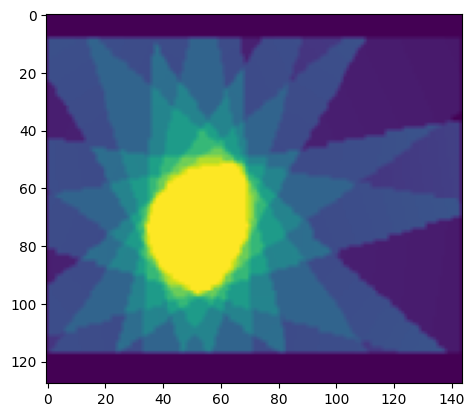

In [10]:
plt.imshow(beam_plate[0, 50])